In [1]:
# Import needed libraries and classes

import os
import matplotlib.pyplot as plt

import random
import numpy as np
import tensorflow
import keras_tuner as kt

import tensorflow.keras.preprocessing as preprocessing
from keras.src.callbacks import EarlyStopping
from tensorflow.keras import models, initializers, optimizers
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.layers import GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import SGD

from Code.utils.dataset import Dataset
import Code.utils.store_model as store_model

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mrjoa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
seed=42
np.random.seed(seed)
tensorflow.random.set_seed(seed)
random.seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
embeddings_initializer=initializers.GlorotUniform(seed=seed)

In [3]:
epochs = 10
def build_model(hp):
    min_hidden = 2
    max_hidden = 16

    hp1_units = hp.Int('hidden1_units', min_value = min_hidden,max_value = max_hidden, step = min_hidden)
    hp2_units = hp.Int('hidden2_units', min_value = min_hidden,max_value = max_hidden, step = min_hidden)
    hp_learning_rate = hp.Choice('learning_rate', values = [0.1, 0.01, 0.001])
    hp_momentum = hp.Choice('momentum', values = [0.5, 0.9, 0.95])
    hp_batch = hp.Choice('batch', values = [4, 8, 16])

    model = models.Sequential()
    model.add(Embedding(max_words, epochs))

    model.add(LSTM(hp1_units, return_sequences=True, kernel_initializer=GlorotUniform(seed=seed), activation='tanh', recurrent_activation='hard_sigmoid'))

    model.add(LSTM(hp2_units, kernel_initializer=GlorotUniform(seed=seed), activation='tanh', recurrent_activation='hard_sigmoid'))

    model.add(Dense(1, activation='sigmoid'))

    optimizer = SGD(learning_rate=hp_learning_rate, momentum=hp_momentum)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

    return model


In [4]:
# Load datasets
dataset = Dataset('../../Dataset/DatasetsGerados/dataset_training_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_training_output.csv',
                  '../../Dataset/DatasetsGerados/dataset_validation_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_validation_output.csv',
                  '../../Dataset/dataset1_inputs.csv',
                  '../../Dataset/dataset1_outputs.csv')

X_train, y_train, X_validation, y_validation, X_test, y_test, ids = dataset.get_datasets_unprocessed('Text', 'Label', sep='\t', rem_punctuation=True)

In [5]:
#tokenization

max_words = 1500
max_len = 200

tokenizer = Tokenizer(num_words=max_words)  # limit to top max_words words
tokenizer.fit_on_texts(X_train.iloc[:, 0])

X_train = tokenizer.texts_to_sequences(X_train.iloc[:, 0])
X_validation = tokenizer.texts_to_sequences(X_validation.iloc[:, 0])
X_test = tokenizer.texts_to_sequences(X_test.iloc[:, 0])

X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_validation = preprocessing.sequence.pad_sequences(X_validation, maxlen=max_len)
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

In [6]:
#Start Tuner
tuner = kt.Hyperband(
    build_model,
    objective = 'val_acc',
    max_epochs = epochs,
    factor = 3,
    directory = './KerasTuner',
    project_name = 'Lstm',
    seed = seed,
)

early_stopping = EarlyStopping(monitor = 'val_acc', patience = 2, min_delta = 0.001, restore_best_weights = True)

tuner.search(X_train, y_train, epochs = epochs, validation_data = (X_validation, y_validation), callbacks = [early_stopping])

Trial 30 Complete [00h 00m 52s]
val_acc: 0.9919999837875366

Best val_acc So Far: 0.9959999918937683
Total elapsed time: 00h 10m 36s


In [ ]:
# Get best values
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

hidden1_units = best_hps['hidden1_units']
hidden2_units = best_hps['hidden2_units']
learning_rate = best_hps['learning_rate']
momentum = best_hps['momentum']
batch = best_hps['batch']

# Build model
model = models.Sequential()
model.add(Embedding(max_words, epochs))

model.add(LSTM(hidden1_units, return_sequences=True, kernel_initializer=GlorotUniform(seed=seed), activation='tanh', recurrent_activation='hard_sigmoid'))

model.add(LSTM(hidden2_units, kernel_initializer=GlorotUniform(seed=seed), activation='tanh', recurrent_activation='hard_sigmoid'))

model.add(Dense(1, activation='sigmoid'))

optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

model.summary()

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch, validation_data=(X_validation,y_validation), callbacks=[early_stopping])

print(f"Hidden Layer 1 has {hidden1_units} units")
print(f"Hidden Layer 2 has {hidden2_units} units")
print(f"Optimizer learning rate = {learning_rate}")
print(f"Optimizer batch size = {batch}")
print(f"Optimizer momentum = {momentum}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
132/188 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - acc: 0.5050 - loss: 0.6973

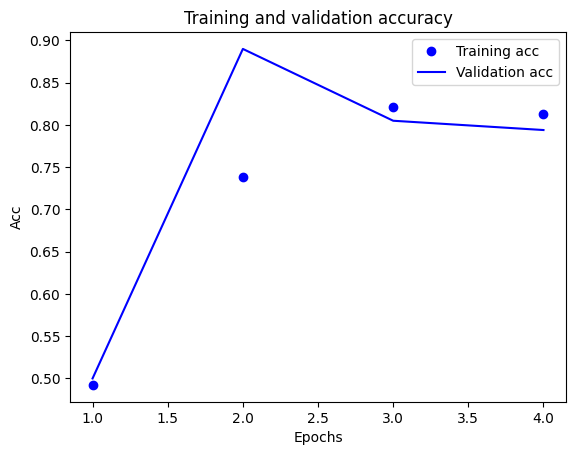

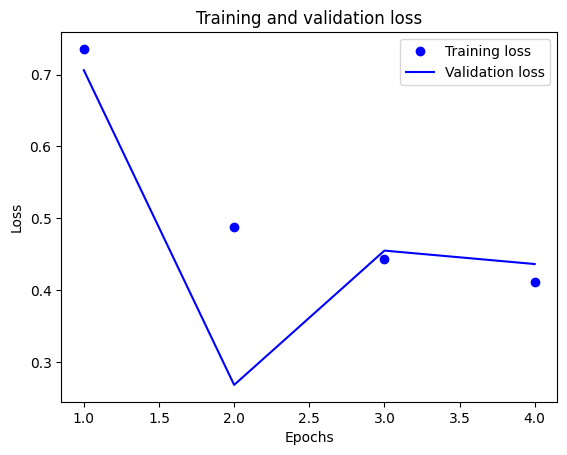

In [8]:
# Plot curves

history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

# Plot loss curves

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# Predict output

output = model.predict(X_test)

if y_test is not None:
    # Evaluate Model

    print(model.evaluate(X_test, y_test))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.6023 - loss: 0.8684 
[0.912720799446106, 0.5874999761581421]


In [10]:
# Store output

results_filepath = './Results/embedding_lstm_results.csv'

# Ensure the directory exists
os.makedirs(os.path.dirname(results_filepath), exist_ok=True)

results = dataset.merge_results(ids, output)
results.to_csv(results_filepath, sep='\t', index=False)

In [11]:
# Store network model

model_filepath = './Model/embedding_lstm'
model_key = 'embedding_lstm'

store_model.store_model(model_filepath, model_key, model)

In [12]:
# Retrieve network model

model_filepath = './Model/embedding_lstm'
model_key = 'embedding_lstm'

model = store_model.retrieve_model(model_filepath, model_key)

In [13]:
dataset.set_dataset_test('../../Dataset/dataset1_inputs.csv', '../../Dataset/dataset1_outputs.csv')

X_test, y_test, ids = dataset.get_test_dataset_unprocessed('Text', 'Label', sep='\t', rem_punctuation=False)

X_test = tokenizer.texts_to_sequences(X_test.iloc[:, 0])
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)